In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import os

In [6]:
species_index = pd.read_pickle('results2/species_index.pkl')
species_index_T = pd.Series(species_index)
species_index_T = pd.Series(species_index_T.index, index = species_index_T.values)
species_index_T = species_index_T.to_dict()

abundances = pd.read_pickle('GAM_species/species_fit_140_0.01.pkl')

In [7]:
data_path = './results2/transfer_entropies/'
start = 0
end = 40

# Load the data
original_table = pd.read_pickle(f'{data_path}/original_table_{start}:{end}.pkl')

tables = []
for i in range(0,1000):
    filename = f"TE_matrix{i}_0:40.pkl"
    filepath = os.path.join(data_path, filename)
    if os.path.exists(filepath):
        tables.append(pd.read_pickle(f'{data_path}/TE_matrix{i}_{start}:{end}.pkl'))
print(len(tables))

p_values = np.zeros(original_table.shape)
for i, table in enumerate(tables):
    p_values += (original_table.values < table.values).astype(int)
p_values /= len(tables)
p_values[np.eye(p_values.shape[0], dtype=bool)] = np.nan

1000


Text(0, 0.5, 'Frequency')

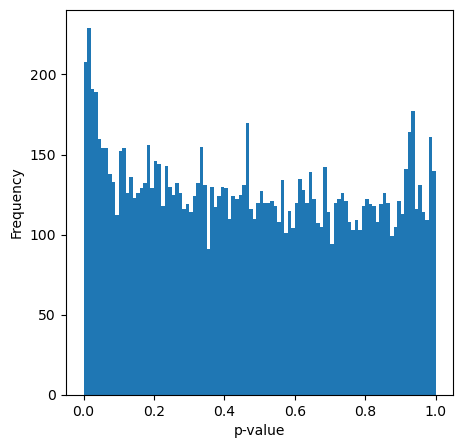

In [8]:
fig,ax = plt.subplots(figsize=(5, 5))
ax.hist(p_values.flatten(), bins = 100)
ax.set_xlabel('p-value')
ax.set_ylabel('Frequency')

In [9]:
import graph_tool.all as gt


# Function that returns a generator for sequential colormap colors
def sequential_color_generator(cmap_name='tab10'):
    cmap = plt.get_cmap(cmap_name)
    index = 0
    while True:
        yield cmap(index % cmap.N)
        index += 1


# Create a graph-tool Graph object from the networkx graph
def SFDP_layout(network):
    g = gt.Graph(directed=False)
    vlist = {}
    for node in network.nodes:
        #add vertex with the same index as in networkx (example: '32848242')
        vlist[node] = g.add_vertex()
        
    for edge in network.edges:
        g.add_edge(vlist[edge[0]], vlist[edge[1]])


    state = gt.minimize_nested_blockmodel_dl(g)
    pos_gt = gt.sfdp_layout(g, groups=state.levels[0].b, gamma=0.001)
    print(state)
    pos = {}
    groups = {}
    generated_colors = {}
    color_gen = sequential_color_generator('tab10')

    for key, value in vlist.items():
        pos[key] = pos_gt[value]
        groups[key] = state.levels[0].b[value]
    for group in set(groups.values()):
        generated_colors[group] = next(color_gen) # np.random.rand(3,)
    colors = [generated_colors[groups[node]] for node in network.nodes]

    return pos, colors

In [10]:
import networkx as nx

# grab the top L edges
L = 100

cut_value = np.sort(p_values.flatten())[L]
print(cut_value)
adjacency = (p_values <= cut_value).astype(int)
graph = nx.from_numpy_array(adjacency, create_using=nx.Graph)

pos, colors = SFDP_layout(graph)

dict_abundances = {x:abundances[x]['y'].sum() for x in abundances.columns}
sizes = [dict_abundances[species_index_T[x]] for x in graph.nodes]

0.004
<NestedBlockState object, with base <BlockState object with 114 blocks (1 nonempty), degree-corrected, for graph <Graph object, undirected, with 114 vertices and 100 edges, at 0x7f95e9567e00>, at 0x7f95e0354c20>, and 8 levels of sizes [(114, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f95e0354ad0>


In [11]:
from matplotlib.colors import LinearSegmentedColormap

def custom_seismic():
    # Colors: red -> gray -> blue
    colors = [
        (0.0, 'red'),
        (0.4, 'red'),
        (0.5, 'gray'),
        (0.6, 'blue'),
        (1.0, 'blue')
    ]
    return LinearSegmentedColormap.from_list('custom_seismic_gray', colors)

In [12]:
# for every edge in the graph, calculate the correlation between the abundances of the two species
correlations_edges = []
for edge in graph.edges:
    species1 = species_index_T[edge[0]]
    species2 = species_index_T[edge[1]]
    abundance1 = abundances[species1]['y']
    abundance2 = abundances[species2]['y']
    correlation = np.corrcoef(abundance1, abundance2)[0, 1]
    correlations_edges.append(correlation)
correlation_edges = np.array(correlations_edges)

# used for coloring the edges: green if positive correlation, red if negative
def get_edge_color(correlation):
    if correlation > 0: return 'green'
    else: return 'red'
edge_colors = [get_edge_color(correlation) for correlation in correlation_edges]
edge_colors = [custom_seismic()((correlation+1)/2) for correlation in correlation_edges]

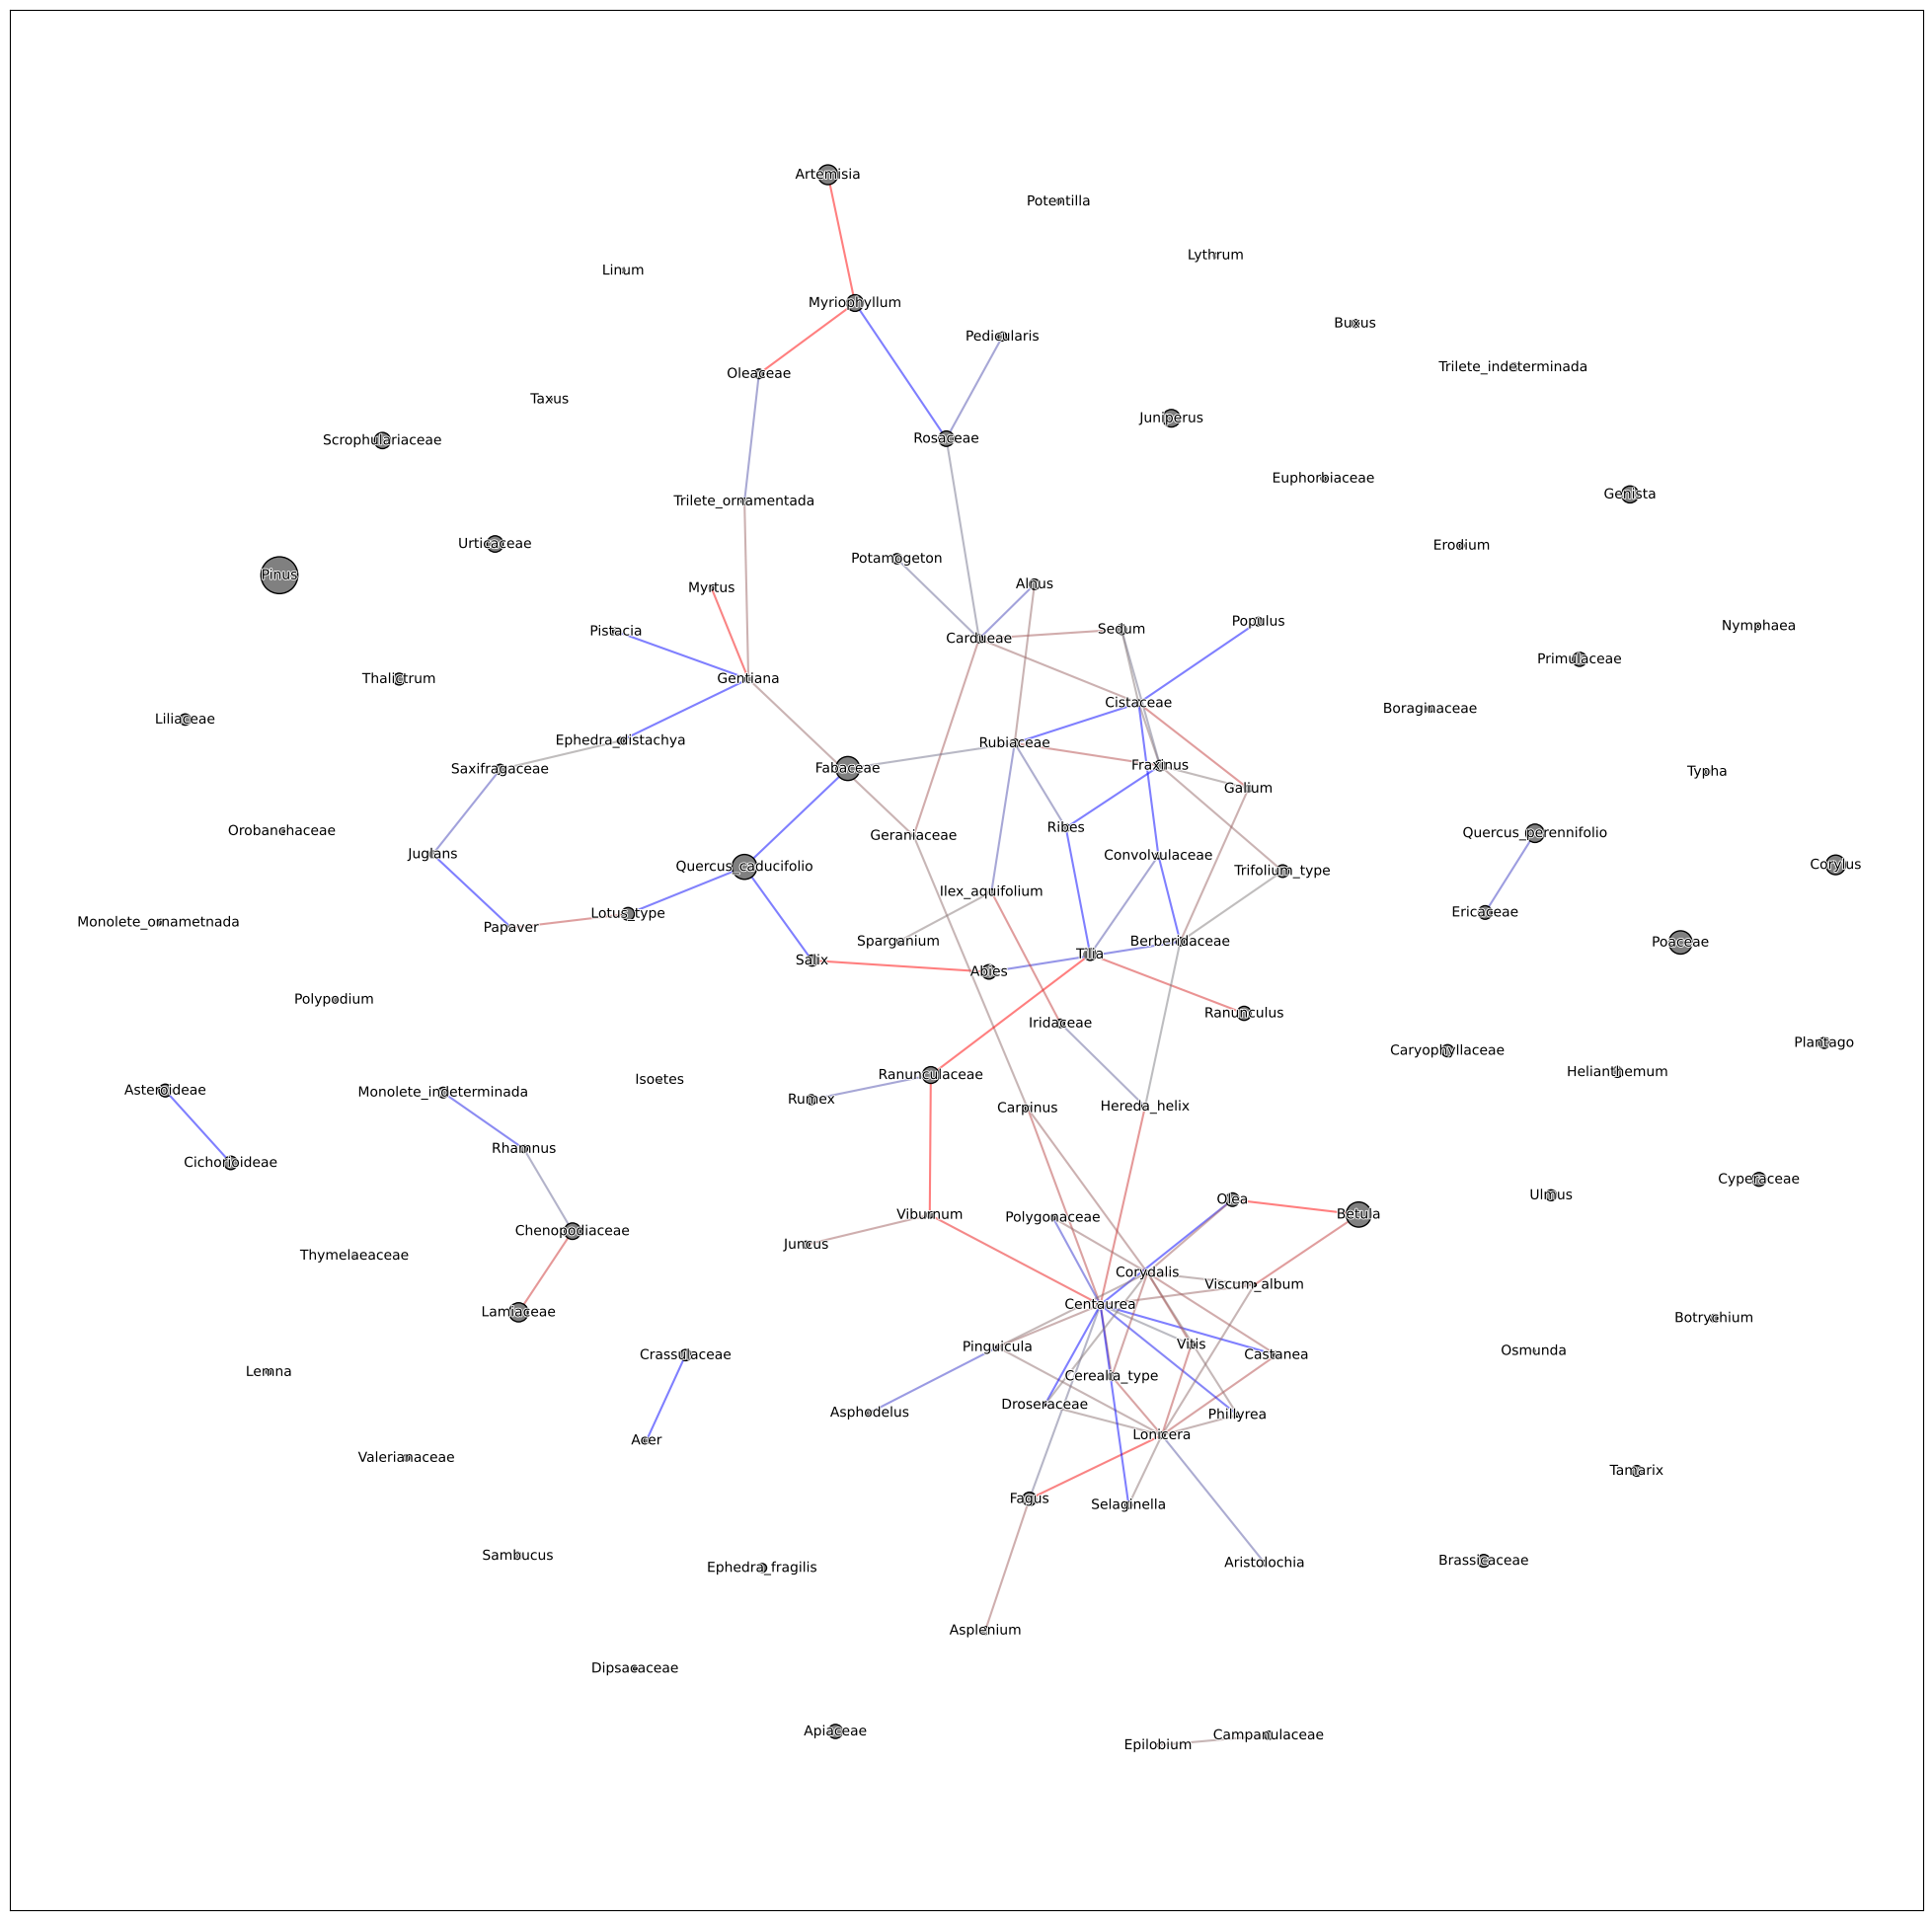

In [13]:

fig,ax = plt.subplots(figsize=(25, 25))

nx.draw_networkx_nodes(graph, ax = ax, node_size=[np.sqrt(size)*100 for size in sizes], node_color='grey', pos=pos, edgecolors='black', linewidths=1, alpha=1)

nx.draw_networkx_edges(graph, ax = ax, alpha = 0.5, pos=pos, width=1.5, edge_color=edge_colors)

texts = nx.draw_networkx_labels(graph, ax = ax, font_size=10, labels=species_index_T,
                        pos=pos, font_color='black', font_family='sans-serif');

for text in texts.values():
    text.set_path_effects([path_effects.Stroke(linewidth=1.3, foreground='white'),
                       path_effects.Normal()])
fig.savefig(f'results2/TE_network_{start}:{end}.pdf', dpi=200, bbox_inches='tight')

In [45]:
# highest degrees

degrees = pd.DataFrame(graph.degree(), columns=['node', 'degree'])
degrees['node'] = degrees['node'].map(species_index_T)
degrees.sort_values(by='degree', ascending=False, inplace=True)
degrees

,node,degree
71,Geraniaceae,63
83,Galium,39
30,Hereda_helix,35
66,Berberidaceae,34
62,Corydalis,32
...,...,...
61,Linum,4
107,Monolete_ornametnada,4
73,Dipsacaceae,3
69,Scrophulariaceae,3


Text(0, 0.5, 'Frequency')

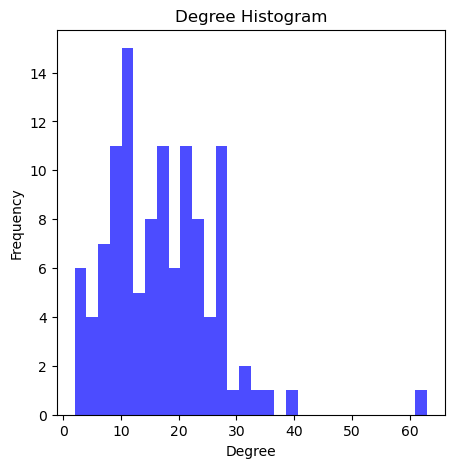

In [46]:
# degree distribution

plt.figure(figsize=(5, 5))
plt.hist(degrees['degree'], bins=30, color='blue', alpha=0.7)
plt.title("Degree Histogram")
plt.xlabel("Degree")
plt.ylabel("Frequency")

Berberidaceae


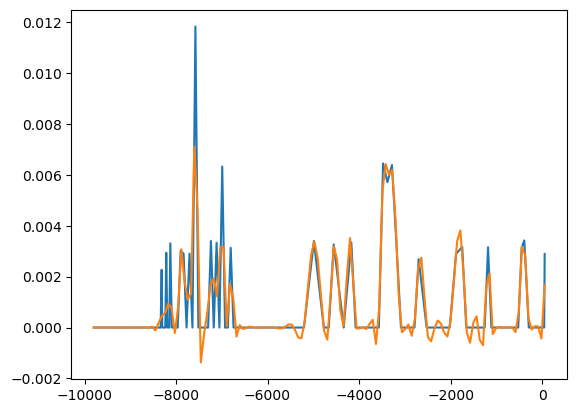

In [59]:
species1 = degrees['node'].iloc[3]
print(species1)
plt.plot(abundances[species1]['prev_x'], abundances[species1]['prev_y'])
plt.plot(abundances[species1]['x'], abundances[species1]['y'])
